# Project 1 - Support Vector Machine Classification {-}

### NAME(S): Sammy Muench, Jake Lawton {-}
### DATE: 4/12/2023 {-}

## What will we do? {-}
Using gradient descent, we will build a Support Vector Machine to find the optimal hyperplane that maximizes the margin between two toy data classes.

## What are some use cases for SVMs? {-}

-Classification, regression (time series prediction, etc.), outlier detection, clustering

## How does an SVM compare to other ML algorithms? {-}


![alt text](images/img.png)
Classifiers: (a) Logistic Regression, (b) SVM, and (c) Multi-Layer Perception (MLP)
* As a rule of thumb, SVMs are great for relatively small data sets with fewer outliers.
* Other algorithms (Random forests, deep neural networks, etc.) require more data but almost always develop robust models.
* The decision of which classifier to use depends on your dataset and the general complexity of the problem.
* "Premature optimization is the root of all evil (or at least most of it) in programming." - Donald Knuth, CS Professor (Turing award speech 1974)

## Other Examples {-}

- Learning to use Scikit-learn's SVM function to classify images https://github.com/ksopyla/svm_mnist_digit_classification
- Pulse classification, more useful dataset
https://github.com/akasantony/pulse-classification-svm

## What is a Support Vector Machine? {-}

It's a supervised machine learning algorithm that can be used for both classification and regression problems. But it's usually used for classification. Given two or more labeled data classes, it acts as a discriminative classifier, formally defined by an optimal hyperplane that separates all the classes. New examples mapped into that space can then be categorized based on which side of the gap they fall.

## What are Support Vectors? {-}

![alt text](images/SvmMargin2.jpg "Logo Title Text 1")

Support vectors are the data points nearest to the hyperplane, the points of a data set that, if removed, would alter the position of the dividing hyperplane. Because of this, they can be considered the critical elements of a data set; they help us build our SVM.


## What is a hyperplane? {-}

![alt text](images/Hyperplanes+as+decision+surfaces.jpg "Logo Title Text 1")

Geometry tells us that a hyperplane is a subspace of one dimension less than its ambient space. For instance, a hyperplane of an n-dimensional space is a flat subset with size $n − 1$. By its nature, it separates the space in half.

## Linear vs nonlinear classification? {-}

Sometimes our data is linearly separable. That means for N classes with M features. We can learn a mapping that is a linear combination. (like $y = mx + b$). Or even a multidimensional hyperplane ($y = x + z + b + q$). No matter how many dimensions/features a set of classes have, we can represent the mapping using a linear function.

But sometimes it is not. Like if there was a quadratic mapping. Luckily for us, SVMs can efficiently perform a non-linear classification using what is called the kernel trick.

![alt text](images/1_mCwnu5kXot6buL7jeIafqQ.png "Logo Title Text 1")

More on this as a Bonus question comes at the end of notebook.

All right, let's get to the building!

# Instructions {-}

In this assignment, you will implement a support vector machine (SVM) from scratch, and you will use your implementation for multiclass classification on the MNIST dataset.


In `implementation.py` implement the SVM class. In the fit function, use `scipy.minimize` ([see documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)) to solve the constrained optimization problem:

$$\begin{align*}
& \underset{a}{\text{maximize}}& & \sum_{i=1}^{n}a_{i} - \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}a_{i}a_{j}y_{i}y_{j}(x_{i}\cdot x_{j}) \\
& \text{subject to}& & a_{i} \ge 0, i=1,\ldots, n \\
& & & \sum_{i=1}^{n}a_{i}y_{i} = 0
\end{align*}$$

__Note__: An SVM is a convex optimization problem. Using  to solve the equation above will be computationally expensive given larger datasets. [CS 168 Convex Optimization](https://www.cs.tufts.edu/t/courses/description/spring2023/CS/168-01) is a course to take later if interested in optimization and the mathematics and intuition that drives it.

In [1]:
import numpy as np
import pandas as pd

from scipy.io import loadmat
from implementation import SVM, linear_kernel, nonlinear_kernel
# from solution import SVM, linear_kernel, nonlinear_kernel
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Step 1 - Get Data {-}

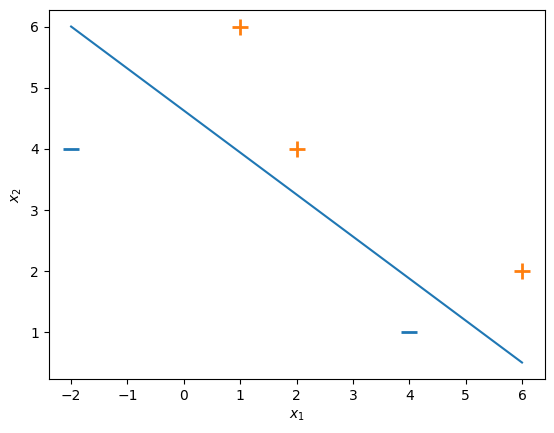

In [2]:
# Input data - of the form [Bias term, x_1 value, x_2 value]
X = np.array([
    [1, -2, 4,],
    [1, 4, 1,],
    [1, 1, 6,],
    [1, 2, 4,],
    [1, 6, 2,],
])

# Associated output labels - first 2 examples are labeled '-1' and last 3 are labeled '+1'
y = np.array([-1,-1,1,1,1])

# Let's plot these examples on a 2D graph!
# Plot the negative samples (the first 2)
plt.scatter(X[:,1][y==-1], X[:,2][y==-1], s=120, marker='_', linewidths=2)
# Plot the positive samples (the last 3)
plt.scatter(X[:,1][y==1], X[:,2][y==1], s=120, marker='+', linewidths=2)

# Print a possible hyperplane, that is separating the two classes.
# we'll two points and draw the line between them (naive guess)
plt.plot([-2,6],[6,0.5])
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

### SVM basics {-}
SVM using scikit-learn.

In [3]:
result = SVC(kernel="linear")
result.fit(X, y.ravel())

print("scikit-learn indices of support vectors:", result.support_)


scikit-learn indices of support vectors: [0 1 3 4]


## Implement and test SVM to sklearn's version (20 points) {-}
Compare the indices of support vectors from scikit-lean with `implementation.py` using toy data.

In [4]:
result = SVC(kernel="linear")
result.fit(X, y)

svm = SVM(kernel=linear_kernel)
svm.fit(X, y)

In [5]:
print("implementation.py indices of support vectors:", \
      np.array(range(y.shape[0]))[svm.a>1e-8])

if (result.support_ != np.array(range(y.shape[0]))[svm.a>1e-8]).all():
    raise Exception("The calculation is wrong")

implementation.py indices of support vectors: [0 1 3 4]


Compare the weights assigned to the features from scikit-lean with `implementation.py`.

In [6]:
print("scikit-learn weights assigned to the features:", result.coef_)
print("implementation.py weights assigned to the features:", svm.w)

print(len(result.coef_))
print(result.coef_.shape)

diff = svm.w - result.coef_
if (diff > 1e-3).any():
    raise Exception("The calculation is wrong")

scikit-learn weights assigned to the features: [[0.         0.5        0.99969451]]
implementation.py weights assigned to the features: [[0.         0.49998619 1.00000347]]
1
(1, 3)


Compare the bias weight from scikit-lean with `implementation.py`.

In [7]:
print("scikit-learn bias weight:", result.intercept_)
print("implementation.py bias weight:", svm.b)

diff = abs(result.intercept_ - svm.b)
if (diff > 1e-3).all():
    raise Exception("The calculation is wrong")

scikit-learn bias weight: [-3.99915989]
implementation.py bias weight: [-3.99998278]


Compare the predictions from scikit-lean with `implementation.py`.

In [8]:
X_test = np.array([
    [4, 4, -1],
    [1, 3, -1]
    ])
print("scikit-learn predictions:", result.predict(X_test))
print("implementation.py predictions:", svm.predict(X_test))

if (svm.predict(X_test) != result.predict(X_test)).all():
    raise Exception("The calculation is wrong")

scikit-learn predictions: [-1 -1]
implementation.py predictions: [[-1.]
 [-1.]]


### Using SKLearns SVM (*one-versus-the-rest*) {-}

You can load the data with `scipy.io.loadmat`, which will return a Python dictionary containing the test and train data and labels.

In [9]:
mnist = loadmat('data/MNIST.mat')
train_samples = mnist['train_samples']
train_samples_labels = mnist['train_samples_labels']
test_samples = mnist['test_samples']
test_samples_labels = mnist['test_samples_labels']

# print(mnist)

## Explore the MNIST dataset {-}
Explore the MNIST dataset:


In [10]:
df_train_samples = pd.DataFrame(train_samples)
# print(df_train_samples.head(5))

df_test_samples = pd.DataFrame(test_samples)
# print(df_test_samples.head(-5))

### *one-versus-the-rest* (15 Points) and analysis {-}
Using your implementation, compare multiclass classification performance of *one-versus-the-rest*

**Create your own implementation of *one-versus-the-rest* and *one-versus-one*. Do not use sklearns multiclass SVM.**

In [11]:
label_range = np.arange(train_samples_labels.min(), train_samples_labels.max() + 1, 1)
SVMlist = [] #initialize SVMlist
fprSVM = []
tprSVM = []
thrSVM = []
OVA_labels_train = []
OVA_labels_test = []

for i, label in enumerate(label_range):
    OVA_labels_train.append([1 if train_samples_labels[j] == label else -1 for j in range(len(train_samples_labels))])
    OVA_labels_test.append([1 if test_samples_labels[j] == label else -1 for j in range(len(test_samples_labels))])
    SVMlist.append(SVC(kernel=linear_kernel, probability = True))
    SVMlist[i].fit(np.array(df_train_samples), np.array(OVA_labels_train[i]))

train_prediction_probs = np.zeros((len(df_train_samples), len(label_range)))
for i, svm in enumerate(SVMlist):
    train_prediction_probs[:, i] = svm.predict_proba(df_train_samples)[:, 1]

test_prediction_probs = np.zeros((len(df_test_samples), len(label_range)))
for i, svm in enumerate(SVMlist):
    test_prediction_probs[:, i] = svm.predict_proba(df_test_samples)[:, 1]
    fpr, tpr, thr = roc_curve(OVA_labels_test[i], test_prediction_probs[:, i])
    fprSVM.append(fpr)
    tprSVM.append(tpr)
    thrSVM.append(thr)



In [12]:
train_predictions = [np.argmax(train_prediction_probs[i]) for i in range(len(df_train_samples))]
test_predictions = [np.argmax(test_prediction_probs[i]) for i in range(len(df_test_samples))]



Determine the accuracy

In [13]:
train_accuracy = np.mean(train_predictions == train_samples_labels[:, 0])
test_accuracy = np.mean(test_predictions == test_samples_labels[:, 0])
print("Train accuracy: {:.2f}".format(100*train_accuracy))
print("Test accuracy: {:.2f}".format(100*test_accuracy))

Train accuracy: 91.83
Test accuracy: 88.60


The parameter $C>0$ controls the tradeoff between the size of the margin and the slack variable penalty. It is analogous to the inverse of a regularization coefficient. Include in your report a brief discussion of how you found an appropriate value.

In [14]:
train_accuracies = list()
test_accuracies = list()
label_range = np.arange(train_samples_labels.min(), train_samples_labels.max() + 1, 1)

for C in np.logspace(-5, 5, num=11):
    SVMlist = [] #initialize SVMlist
    for i, label in enumerate(label_range):
        SVMlist.append(SVC(kernel=linear_kernel, probability = True, C=C))
        SVMlist[i].fit(np.array(df_train_samples), np.array(OVA_labels_train[i]))

    train_prediction_probs = np.zeros((len(df_train_samples), len(label_range)))
    for i, svm in enumerate(SVMlist):
        train_prediction_probs[:, i] = svm.predict_proba(df_train_samples)[:, 1]

    test_prediction_probs = np.zeros((len(df_test_samples), len(label_range)))
    for i, svm in enumerate(SVMlist):
        test_prediction_probs[:, i] = svm.predict_proba(df_test_samples)[:, 1]
    
    train_predictions = [np.argmax(train_prediction_probs[i]) for i in range(len(df_train_samples))]
    test_predictions = [np.argmax(test_prediction_probs[i]) for i in range(len(df_test_samples))]

    train_accuracies.append([C, np.mean(train_predictions == train_samples_labels[:, 0])])
    test_accuracies.append([C, np.mean(test_predictions == test_samples_labels[:, 0])])



In [15]:
train_accuracies = np.array(train_accuracies)
test_accuracies = np.array(test_accuracies)


print('best C value for training set:', train_accuracies[np.argmax(train_accuracies[:, 1]), 0])
print('best C value for test set:', test_accuracies[np.argmax(test_accuracies[:, 1]), 0])

best C value for training set: 10000.0
best C value for test set: 10.0


Provide details on how you found an appropriate value.

We ran a np.logspace and put the (C, accuracy) tuple in a train_accuracy and test_accuracy list. We then found the maximum C value in each train, test set and took the accuracy associated with it.

Plot accuracies for train and test using logspace for x-axis (i.e., $C$ values)

train (C, acc) [[1.0000e-05 7.9850e-01]
 [1.0000e-04 8.4625e-01]
 [1.0000e-03 8.6775e-01]
 [1.0000e-02 8.6825e-01]
 [1.0000e-01 8.7875e-01]
 [1.0000e+00 9.1825e-01]
 [1.0000e+01 9.4700e-01]
 [1.0000e+02 9.8125e-01]
 [1.0000e+03 9.9725e-01]
 [1.0000e+04 1.0000e+00]
 [1.0000e+05 1.0000e+00]]
test (C, acc) [[1.00e-05 7.62e-01]
 [1.00e-04 8.12e-01]
 [1.00e-03 8.40e-01]
 [1.00e-02 8.41e-01]
 [1.00e-01 8.49e-01]
 [1.00e+00 8.85e-01]
 [1.00e+01 8.86e-01]
 [1.00e+02 8.47e-01]
 [1.00e+03 8.25e-01]
 [1.00e+04 8.12e-01]
 [1.00e+05 8.19e-01]]


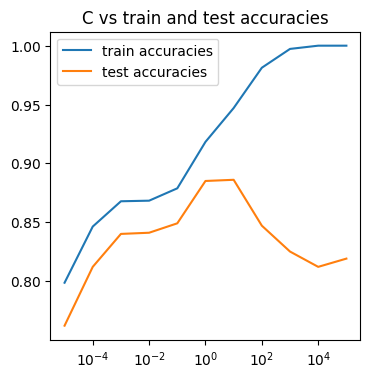

In [16]:
Crange = np.logspace(-5, 5, num=11)

print('train (C, acc)', train_accuracies)
print('test (C, acc)', test_accuracies)

fig, ax = plt.subplots(figsize = (4, 4))
ax.plot(Crange, train_accuracies[:, 1], label = 'train accuracies')
ax.plot(Crange, test_accuracies[:, 1], label='test accuracies')
ax.set_xscale('log')
ax.set_title('C vs train and test accuracies')
ax.legend()

What does this graph tell us about the importance of our C value?

The C value clearly has some effect on accuracy. There is an optimal C value at C = 10, and as C increases after that, the model becomes overfit, as shown by the decrease in test data accuracy.

### (10 Points) {-}
In addition to calculating percent accuracy, generate multiclass [confusion matrices](https://en.wikipedia.org/wiki/confusion_matrix) as part of your analysis.

In [17]:
print('Train Matrix (row = predicted, col = true):')
train_matrix = np.zeros((len(label_range), len(label_range)))


for index, element in enumerate(train_predictions):
    train_matrix[element, train_samples_labels[index]] = train_matrix[element, train_samples_labels[index]] + 1

print(train_matrix)


Train Matrix (row = predicted, col = true):
[[382.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 451.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 410.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 413.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 417.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 347.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 394.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 412.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 373.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 401.]]


In [18]:
test_matrix = np.zeros((len(label_range), len(label_range)))


for index, element in enumerate(test_predictions):
    test_matrix[element, test_samples_labels[index]] = test_matrix[element, test_samples_labels[index]] + 1

print('Test Matrix (row = predicted, col = true):')
print(test_matrix)


Test Matrix (row = predicted, col = true):
[[ 79.   0.   0.   0.   1.   2.   3.   2.   0.   0.]
 [  0. 120.   4.   0.   1.   0.   1.   2.   1.   2.]
 [  0.   0.  92.   5.   2.   2.   3.   4.   1.   2.]
 [  1.   0.   5.  87.   0.   7.   0.   3.   5.   2.]
 [  0.   0.   0.   1.  90.   2.   1.   0.   6.   9.]
 [  3.   1.   0.  12.   0.  66.   1.   0.   6.   0.]
 [  1.   0.   1.   3.   3.   1.  74.   0.   0.   0.]
 [  0.   0.   3.   3.   0.   0.   2.  81.   2.   5.]
 [  0.   1.   5.   0.   4.   9.   1.   1.  61.   3.]
 [  2.   0.   3.   4.   7.   3.   1.   6.   4.  69.]]


### Evaluation (15 points) {-}

Now we will report our results and compare to other algorithms. Usually compare with a handful
Logisitic regression

**Create your own implementation of *one-versus-the-rest* and *one-versus-one*. Do not use sklearns multiclass Logistic Regression.**

In [19]:
label_range = np.arange(train_samples_labels.min(), train_samples_labels.max() + 1, 1)
LogRegList = [] #initialize SVMlist
fprLog = []
tprLog = []
thrLog = []

for i, label in enumerate(label_range):
    LogRegList.append(LogisticRegression(random_state=42))
    LogRegList[i].fit(np.array(df_train_samples), np.array(OVA_labels_train[i]))

train_prediction_probs_log = np.zeros((len(df_train_samples), len(label_range)))
for i, log in enumerate(LogRegList):
    train_prediction_probs_log[:, i] = log.predict_proba(df_train_samples)[:, 1]

test_prediction_probs_log = np.zeros((len(df_test_samples), len(label_range)))
for i, log in enumerate(LogRegList):
    test_prediction_probs_log[:, i] = log.predict_proba(df_test_samples)[:, 1]
    fpr, tpr, thr = roc_curve(OVA_labels_test[i], test_prediction_probs_log[:, i])
    fprLog.append(fpr)
    tprLog.append(tpr)
    thrLog.append(thr)


train_predictions_log = [np.argmax(train_prediction_probs_log[i]) for i in range(len(df_train_samples))]
test_predictions_log = [np.argmax(test_prediction_probs_log[i]) for i in range(len(df_test_samples))]



Create a table comparing model accuracy on train and test data.

In [20]:
train_accuracy_log = np.mean(train_predictions_log == train_samples_labels[:, 0])
test_accuracy_log = np.mean(test_predictions_log == test_samples_labels[:, 0])
print("Train accuracy: {:.2f}".format(100*train_accuracy_log))
print("Test accuracy: {:.2f}".format(100*test_accuracy_log))

print(pd.DataFrame({'Type': ['Train', 'Test'], 'Accuracy': [train_accuracy_log, test_accuracy_log]}))

Train accuracy: 89.65
Test accuracy: 87.00
    Type  Accuracy
0  Train    0.8965
1   Test    0.8700


Create 9 graphs (one for each label) with two ROC curves (one for each model).


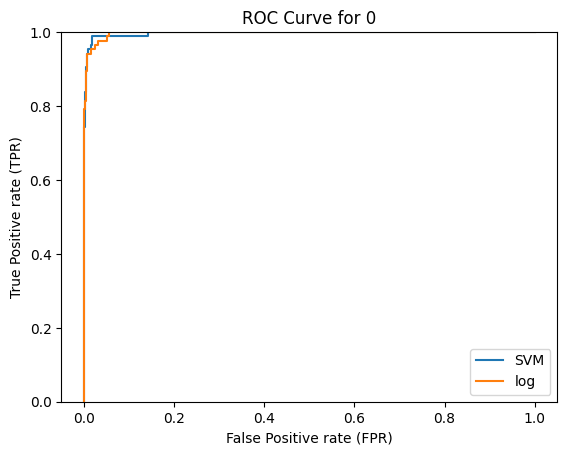

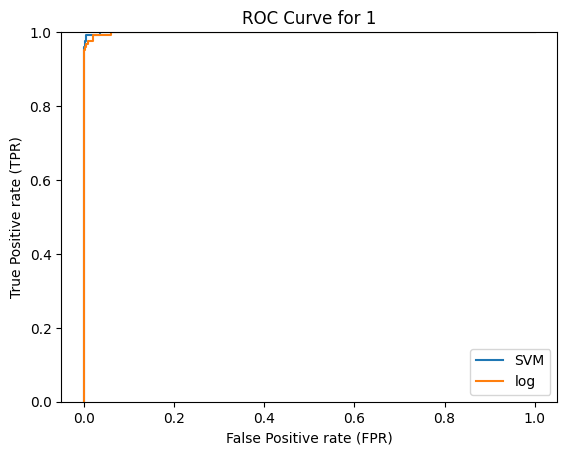

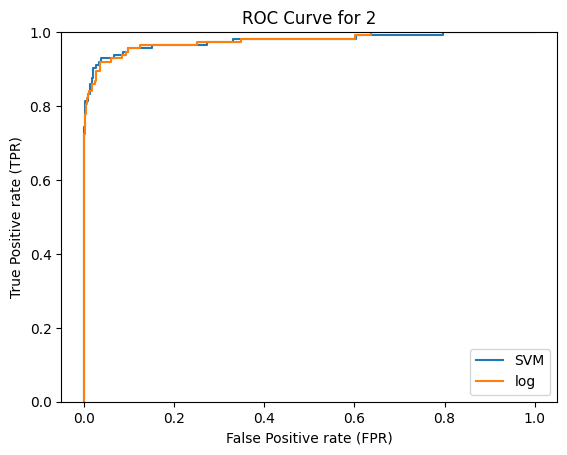

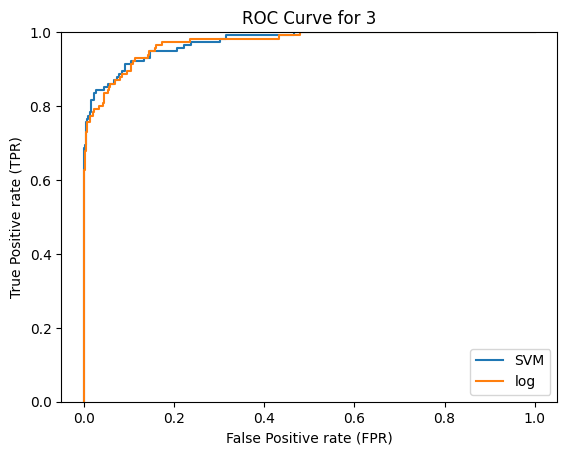

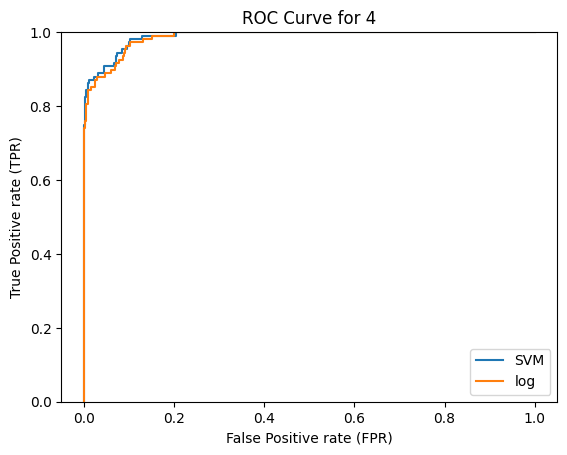

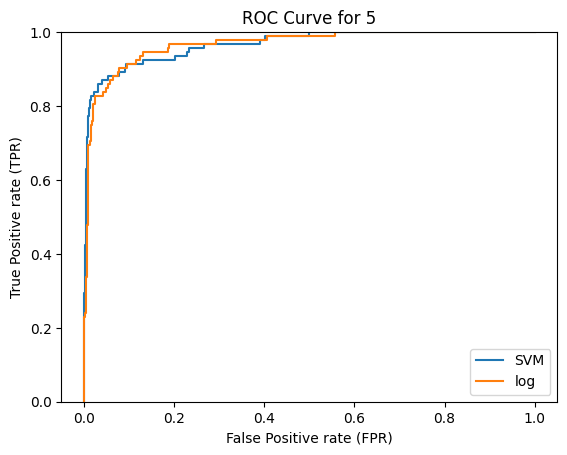

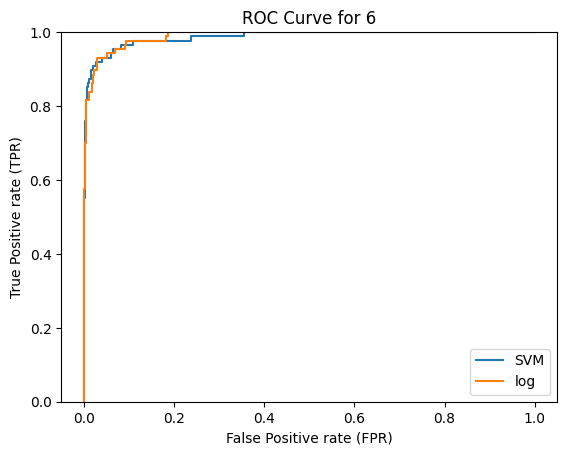

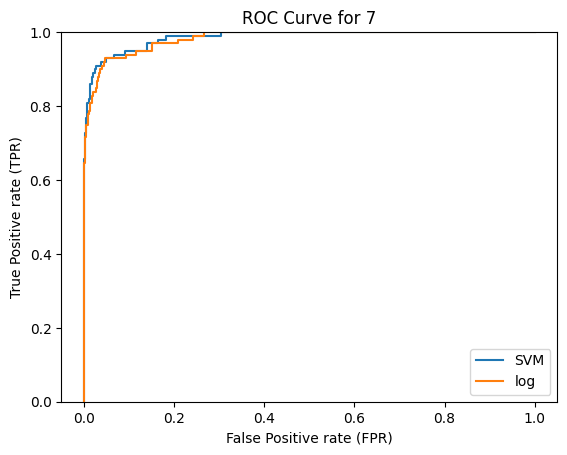

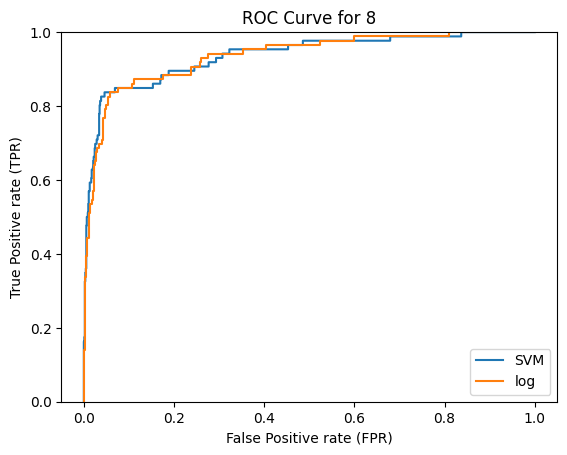

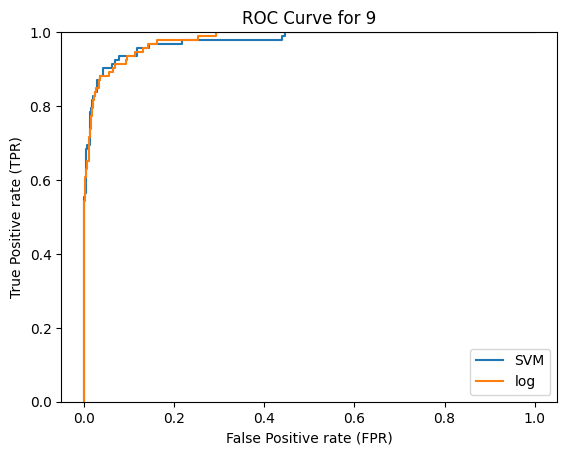

In [21]:
for i, label in enumerate(label_range):
    plt.figure(i+1)
    plt.plot(fprSVM[i], tprSVM[i], label='SVM')
    plt.plot(fprLog[i], tprLog[i], label='log')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.xlabel("False Positive rate (FPR)")
    plt.ylabel("True Positive rate (TPR)")
    plt.title("ROC Curve for {}".format(label))

plt.show()

# BONUS (+5 points): Non-linear kernel {-}
## Intuition Behind Kernels {-}
The SVM classifier obtained by solving the convex Lagrange dual of the primal max-margin SVM formulation is as follows:

$$f(x) = \sum_{i=1}^N\alpha_i\cdot y_i\cdot\mathrm{K}(x,x_i)+b,$$

where $N$ is the number of support vectors.

If you know the intuition behind a linear discriminant function, the non-parametric SVM classifier above is very easy to understand. Instead of imagining the original features of each data point, consider a transformation to a new feature space where the data point has $N$ features, one for each support vector. The value of the $i^{th}$ feature is equal to the value of the kernel between the $i^{th}$ support vector and the data point is classified. The original (possibly non-linear) SVM classifier is like any other linear discriminant in this space.

Note that after the transformation, the original features of the data point are irrelevant. Its dot products with support vectors (special data points chosen by the SVM optimization algorithm) represent it only. One of my professors used a loose analogy while explaining this idea: A person has seen lakes, rivers, streams, fords, etc., but has never seen the sea. How would you explain to this person what a sea is? By relating the amount of water in an ocean to that found in a water body, the person already knows, etc.

In some instances, like the RBF kernel, defining the transformed features in terms of the original features of a data point leads to an infinite-dimensional representation. Unfortunately, though this an awe-inspiring fact often mentioned while explaining how powerful SVMs are, it drops in only after repeated encounters with the idea ranging from introductory machine learning to statistical learning theory.


## Intuition Behind Gaussian Kernels {-}

The Gaussian/RBF kernel is as follows:

$$ \mathrm{K}(x,y)=exp(−\frac{||x−y||^2}{2\sigma^2})$$


Like any other kernel, we can understand the RBF kernel regarding feature transformation via the dot products given above. However, the intuition that helps best when analyzing the RBF kernel is that of the Gaussian distribution (as provided by [Akihiro Matsukawa](https://www.quora.com/profile/Akihiro-Matsukawa)).

The Gaussian kernel computed with a support vector is an exponentially decaying function in the input feature space, the maximum value of which is attained at the support vector and which decays uniformly in all directions around the support vector, leading to hyper-spherical contours of the kernel function. The SVM classifier with the Gaussian kernel is simply a weighted linear combination of the kernel function computed between a data point and each support vector. The role of a support vector in the classification of a data point gets tempered with $\alpha$, the global prediction usefulness of the support vector, and $\mathrm{K}(x,y)$, the local influence of a support vector in prediction at a particular data point.

In the 2D feature space, each support vector's kernel function's heat map decay away from the support vector and the resulting classifier (see the following figure).


## Notion of Universal Kernels {-}

(This comes from learning theory, it could be more intuitive, but good to know.)

Gaussian kernels are universal kernels, i.e., their use with appropriate regularization guarantees a globally optimal predictor, which minimizes a classifier's estimation and approximation errors. Here, we incur approximation error by limiting the space of classification models over which the search space. Estimation error refers to errors in estimating the model parameters.


## Intuition Behind Gaussian Kernels {-}

The Gaussian/RBF kernel is as follows:

$$ \mathrm{K}(x,y)=exp(−\frac{||x−y||^2}{2\sigma^2})$$


Like any other kernel, we can understand the RBF kernel regarding feature transformation via the dot products given above. However, the intuition that helps best when analyzing the RBF kernel is that of the Gaussian distribution (as provided by [Akihiro Matsukawa](https://www.quora.com/profile/Akihiro-Matsukawa)).

The Gaussian kernel computed with a support vector is an exponentially decaying function in the input feature space, the maximum value of which is attained at the support vector and which decays uniformly in all directions around the support vector, leading to hyper-spherical contours of the kernel function. The SVM classifier with the Gaussian kernel is simply a weighted linear combination of the kernel function computed between a data point and each support vector. The role of a support vector in the classification of a data point gets tempered with $\alpha$, the global prediction usefulness of the support vector, and $\mathrm{K}(x,y)$, the local influence of a support vector in prediction at a particular data point.

In the 2D feature space, each support vector's kernel function's heat map decay away from the support vector and the resulting classifier (see the following figure).

![gkernel in 2D](images/gkernel-2d.jpeg " kernel function of each support vector")


### Notion of Universal Kernels {-}
(This comes from learning theory, it could be more intuitive, but good to know.)

Gaussian kernels are universal kernels, i.e., their use with appropriate regularization guarantees a globally optimal predictor, which minimizes a classifier's estimation and approximation errors. Here, we incur approximation error by limiting the space of classification models over which the search space. Estimation error refers to errors in estimating the model parameters.


Implement `nonlinear_kernel()` in `implementation.py`, use it, and compare with others (repeat above for SVM using non-linear kernel and do analysis).

In [22]:
print(len(OVA_labels_train))
print(len(label_range))

10
10


In [23]:
# SVMlist = [] #initialize SVMlist
# sigma = 0.5
# K = np.zeros((len(df_train_samples), len(df_train_samples)))
# print(df_train_samples)
# print(K.shape)
# print(len(df_train_samples))
# for i in range(len(df_train_samples)):
#     if i % 1000 == 0:
#         print('going')
#     for j in range(len(df_train_samples)):
#         print(i, j)
#         K[i, j] = nonlinear_kernel(df_train_samples.T[i], df_train_samples.T[j])

# for i, label in enumerate(label_range):
#     SVMlist.append(SVC(kernel='precomputed', probability=True))
#     SVMlist[i].fit(K, np.array(OVA_labels_train[i]))

In [24]:
# train_prediction_probs = np.zeros((len(df_train_samples), len(label_range)))
# # k = np.zeros(len(df_train_samples))
# # for i in range(len(df_train_samples)):
# #     dist = np.linalg.norm(df_train_samples[i] - X_test)
# #     k[i] = np.exp(-dist**2 / (2*sigma**2))
# for i, svm in enumerate(SVMlist):
#     print('train probs label', label)
#     train_prediction_probs[:, i] = svm.predict_proba(K)[:, 1]

# test_prediction_probs = np.zeros((len(df_test_samples), len(label_range)))
# for i, svm in enumerate(SVMlist):
#     print('test probs label', label)
#     test_prediction_probs[:, i] = svm.predict_proba(df_test_samples.T)[:, 1]

# train_predictions = [np.argmax(train_prediction_probs[i]) for i in range(len(df_train_samples.T))]
# test_predictions = [np.argmax(test_prediction_probs[i]) for i in range(len(df_test_samples.T))]

# train_accuracy = np.mean(train_predictions == train_samples_labels[:, 0])
# test_accuracy = np.mean(test_predictions == test_samples_labels[:, 0])
# print("Train accuracy: {:.2f}".format(100*train_accuracy))
# print("Test accuracy: {:.2f}".format(100*test_accuracy))
